In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import re
import pandas as pd
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

PATH = "/kaggle/input/cbis-ddsm-clean/cbis-ddsm-clean"

In [2]:
malignant_images_paths = sorted(
        glob(os.path.join(PATH,"malignant/*).png")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
malignant_masks_paths = sorted(
        glob(os.path.join(PATH, "malignant/*mask*")),
        key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
    )
# sample array with 'SIZE' mammograms and masks
SIZE = 10
full_mammo = np.zeros((SIZE,), dtype=object)
mask = np.zeros((SIZE,), dtype=object)

data_df = pd.read_csv("/kaggle/input/cbis-ddsm-clean/cbis-ddsm-clean/data_df_malignant.csv")

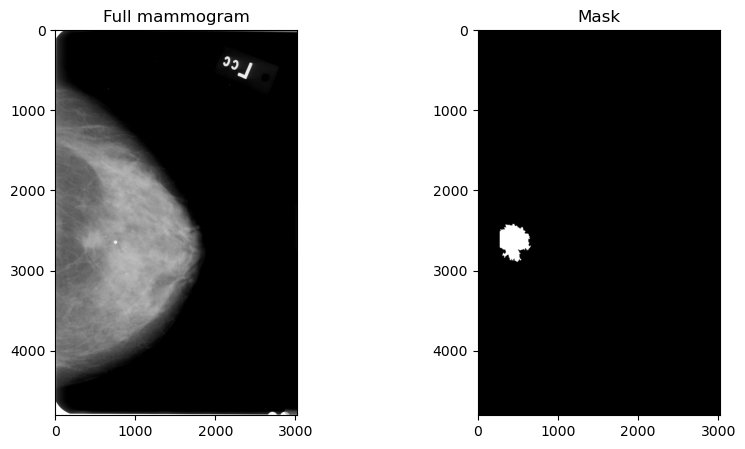

In [3]:
# Show the original image and mask for one mammography 
for i in range (SIZE):
    full_mammo[i] = cv2.imread(malignant_images_paths[i], cv2.IMREAD_GRAYSCALE)
    mask[i] = cv2.imread(malignant_masks_paths[i], cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(full_mammo[0], cmap="gray")
ax[0].set_title("Full mammogram")
ax[1].imshow(mask[0], cmap="gray")
ax[1].set_title("Mask")
plt.show()

In [4]:
# Contrast-limited adaptive histogram equalization
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

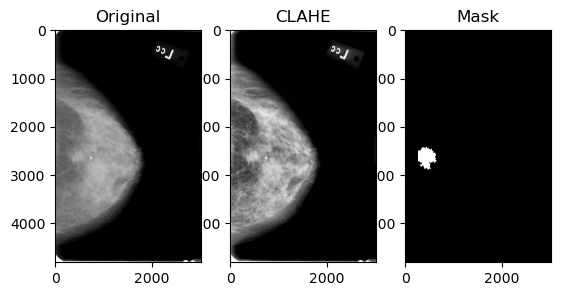

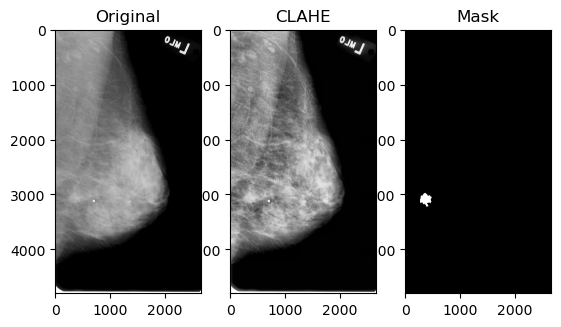

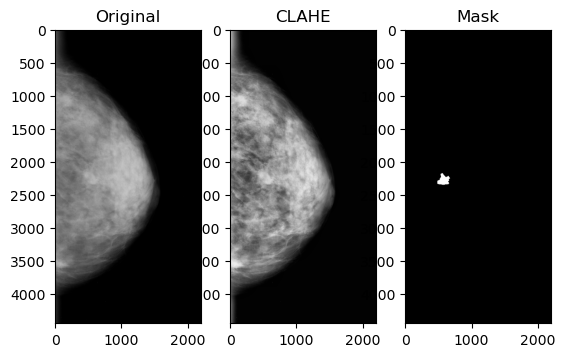

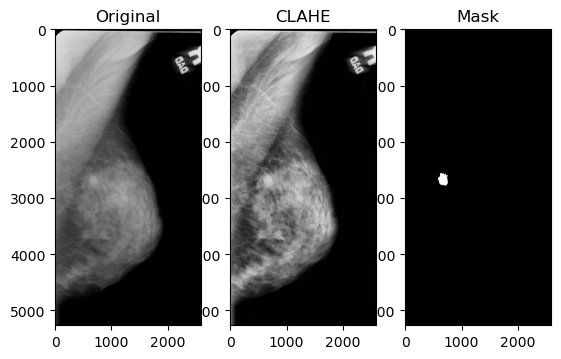

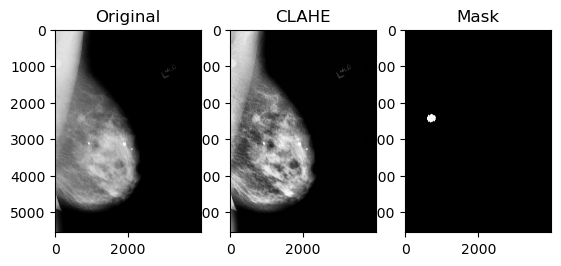

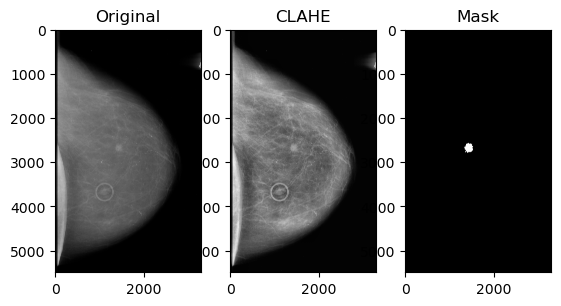

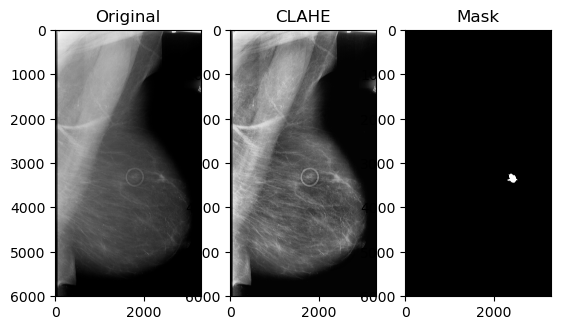

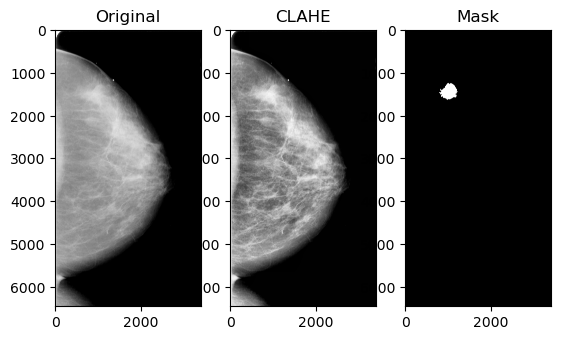

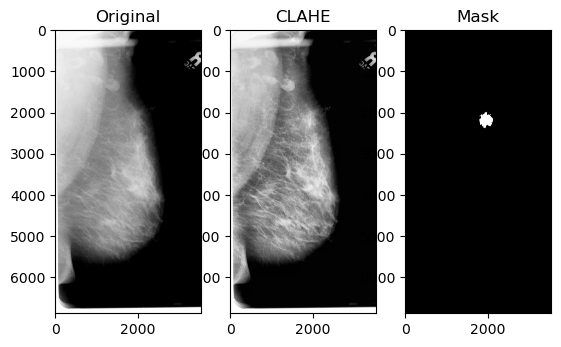

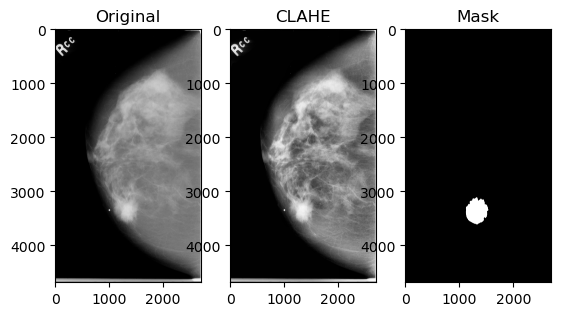

In [5]:
clahe_mammo = np.zeros((SIZE,), dtype=object)

for i in range (SIZE):    
    clahe_mammo[i] = apply_clahe(full_mammo[i])
    
    fig, axs = plt.subplots(1, 3)
    for ax in axs:
        ax.grid(False)
    axs[0].imshow(full_mammo[i],cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(clahe_mammo[i],cmap='gray')
    axs[1].set_title("CLAHE")
    axs[2].imshow(mask[i], cmap="gray")
    axs[2].set_title("Mask")
    plt.show()

In [6]:
# Apply binarization (images are normalized in 0 - 1 and only pixels that have a 
# value that exceeds a certain threshold are kept)
def simple_binarization(full_mammo):
    threshold_value = 50 
    max_value = 255
    _, simple_binarized_mammo = cv2.threshold(full_mammo, threshold_value, max_value, cv2.THRESH_BINARY)
    return simple_binarized_mammo

def otsu_binarization(full_mammo):
    threshold_value, _ = cv2.threshold(full_mammo, 0, 255, cv2.THRESH_OTSU)
    max_value = 255
    _, otsu_binarized_mammo = cv2.threshold(full_mammo, threshold_value, max_value, cv2.THRESH_BINARY)
    return otsu_binarized_mammo

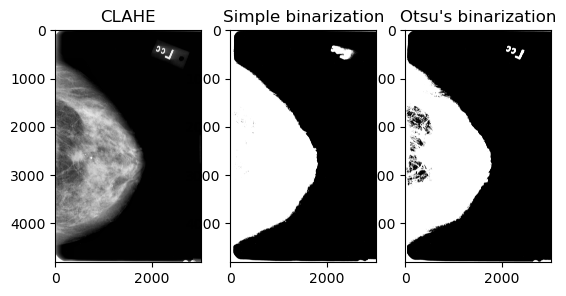

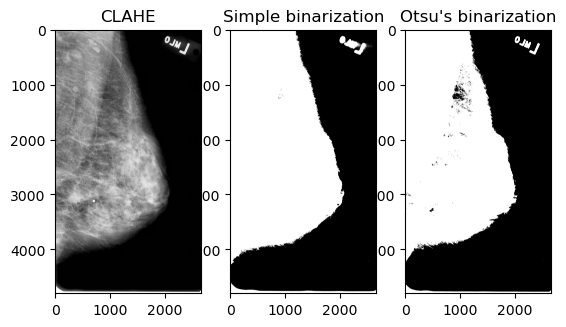

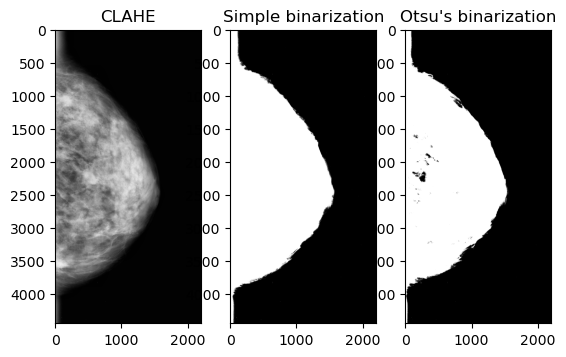

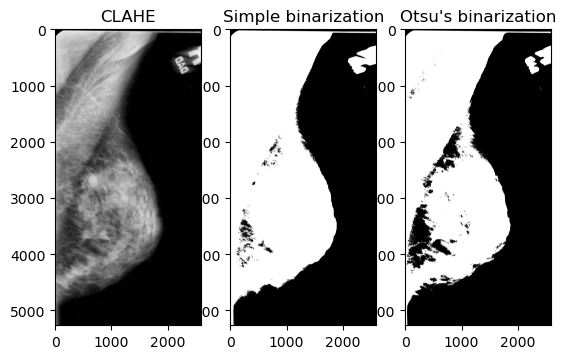

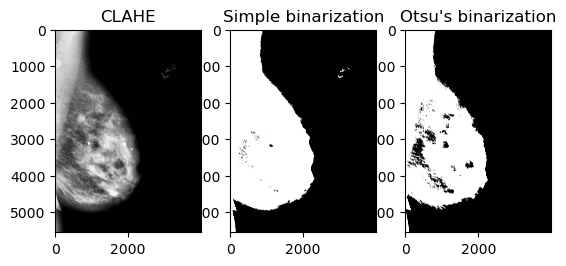

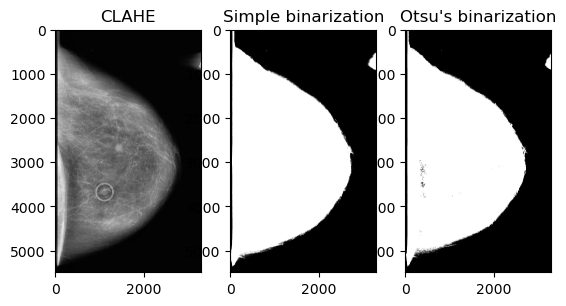

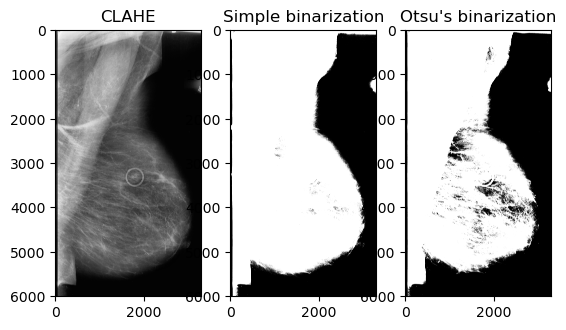

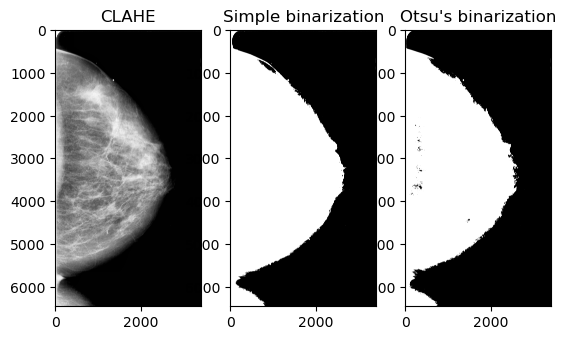

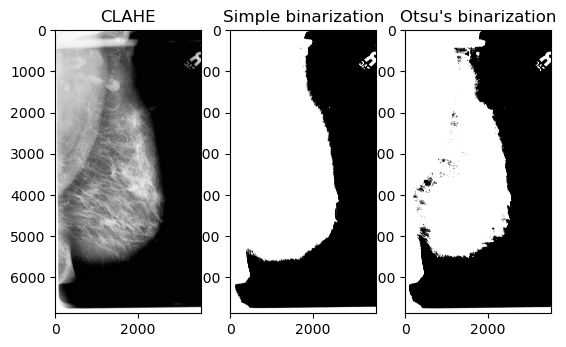

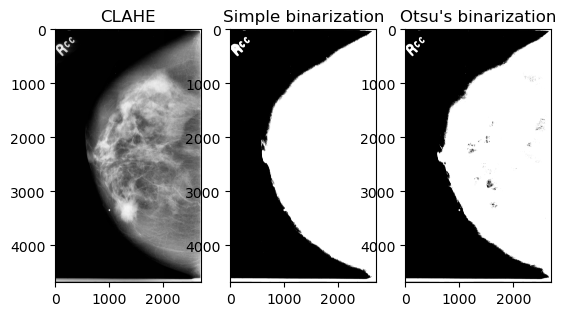

In [7]:
simple_binarized_mammo = np.zeros((SIZE,), dtype=object)
otsu_binarized_mammo = np.zeros((SIZE,), dtype=object)

for i in range (SIZE):    
    simple_binarized_mammo[i] = simple_binarization(clahe_mammo[i])
    otsu_binarized_mammo[i] = otsu_binarization(clahe_mammo[i])
    
    fig, axs = plt.subplots(1, 3)
    for ax in axs:
        ax.grid(False)
    axs[0].imshow(clahe_mammo[i],cmap='gray')
    axs[0].set_title("CLAHE")
    axs[1].imshow(simple_binarized_mammo[i],cmap='gray')
    axs[1].set_title("Simple binarization")
    axs[2].imshow(otsu_binarized_mammo[i],cmap='gray')
    axs[2].set_title("Otsu's binarization")
    plt.show()


In [8]:
# I continue the process with the image obtained with Simple binarization 
# I want to find the largest connected component from the binarized image in order to remove the artefacts that are not important,
# like the letters/words wrote on the mammogram 

def remove_artefacts(full_mammo, simple_binarized_mammo):
    # Apply morphological opening to remove small white regions
    kernel = np.ones((5, 5), np.uint8)
    opened_image = cv2.morphologyEx(simple_binarized_mammo, cv2.MORPH_OPEN, kernel)

    # Apply morphological closing to fill small gaps in the white regions
    closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

    # Find the largest connected component
    contours, hierarchy = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the largest connected component
    mask1 = np.zeros(simple_binarized_mammo.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask1, [largest_contour], -1, 255, -1)

    # Apply the mask to the original image to remove the words/letters
    result = cv2.bitwise_and(full_mammo, full_mammo, mask=mask1)

    return result


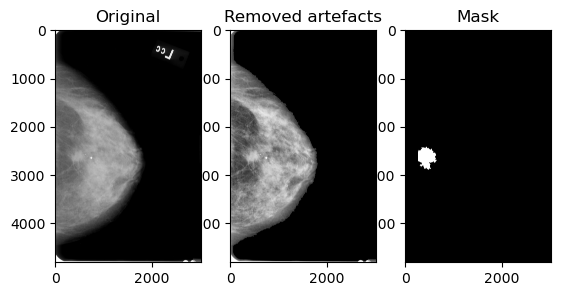

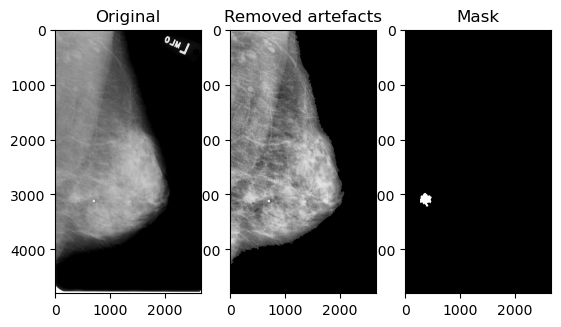

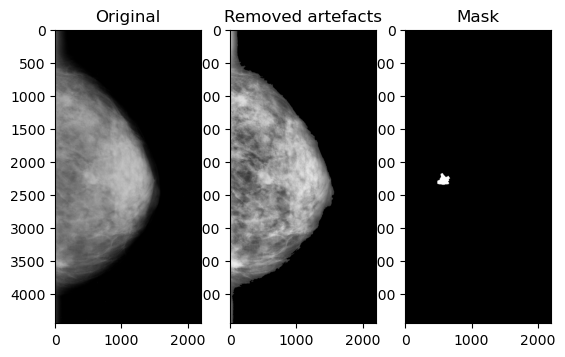

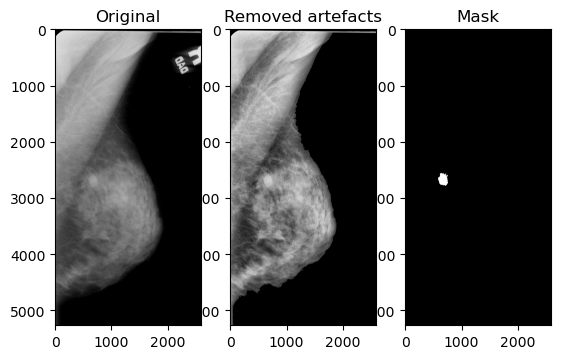

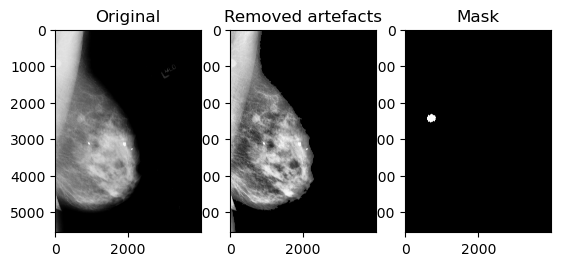

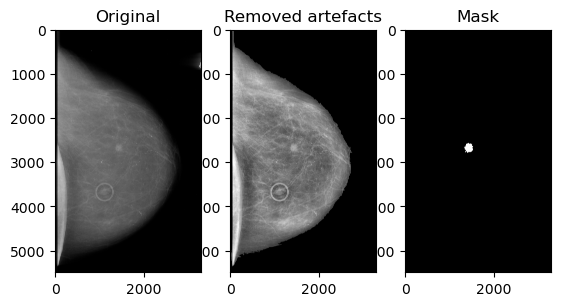

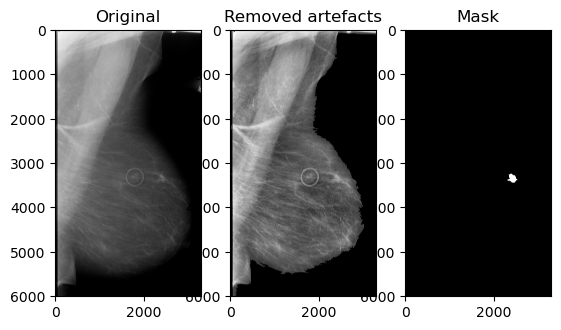

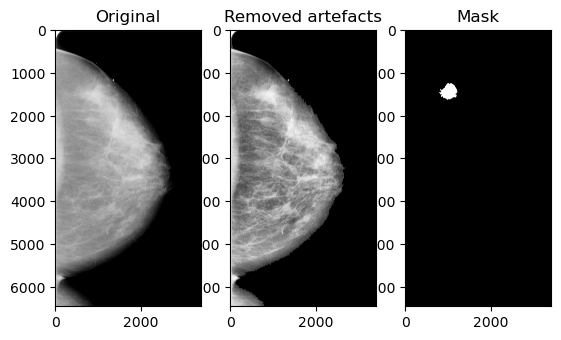

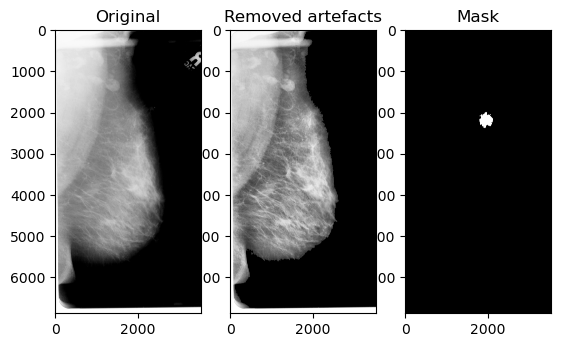

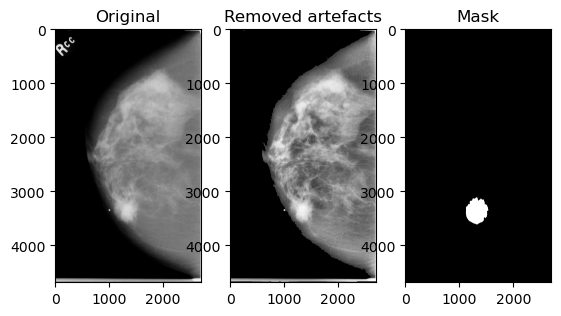

In [9]:
removed_artefacts_mammo = np.zeros((SIZE,), dtype=object)

for i in range (SIZE):   
    removed_artefacts_mammo[i] = remove_artefacts(clahe_mammo[i], simple_binarized_mammo[i])

    fig, axs = plt.subplots(1, 3)
    for ax in axs:
        ax.grid(False)    
    axs[0].imshow(full_mammo[i],cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(removed_artefacts_mammo[i],cmap='gray')
    axs[1].set_title("Removed artefacts")
    axs[2].imshow(mask[i],cmap='gray')
    axs[2].set_title("Mask")
    plt.show()

In [10]:
def is_mlo_view(df_index):
    if(data_df.loc[df_index, 'image view'] == 'MLO'):
            return True
    else:
        return False
    
def determine_breast_side(image, intensity_threshold=0.5):
    height, width = image.shape
    left_sum = np.sum(image[:, :width//2])
    right_sum = np.sum(image[:, width//2:])    
    if left_sum > right_sum * intensity_threshold:
        return "left"
    else:
        return "right"
    
def get_seed_point(image):
    # Get the image dimensions
    rows, cols = image.shape

    # Define the triangle dimensions
    triangle_height = int(rows / 4)
    triangle_base = int(cols / 4)

    seed_x = int(triangle_base * 0.25)
    seed_y = int(triangle_height * 0.25)

    return seed_x, seed_y

def adaptive_similarity(pixel_value, region_mean, local_mean, alpha):
    threshold = alpha * local_mean
    return abs(pixel_value - region_mean) <= threshold

def local_mean(image, x, y, window_size):
    height, width = image.shape
    half_window = window_size // 2
    x_start = max(0, x - half_window)
    x_end = min(width, x + half_window + 1)
    y_start = max(0, y - half_window)
    y_end = min(height, y + half_window + 1)
    return np.mean(image[y_start:y_end, x_start:x_end])

def point_in_triangle(pt, tri_pts):
    x, y = pt
    (x1, y1), (x2, y2), (x3, y3) = tri_pts
    
    alpha = ((y2 - y3) * (x - x3) + (x3 - x2) * (y - y3)) / ((y2 - y3) * (x1 - x3) + (x3 - x2) * (y1 - y3))
    beta = ((y3 - y1) * (x - x3) + (x1 - x3) * (y - y3)) / ((y2 - y3) * (x1 - x3) + (x3 - x2) * (y1 - y3))
    gamma = 1 - alpha - beta
    
    return 0 <= alpha <= 1 and 0 <= beta <= 1 and 0 <= gamma <= 1

def neighbors_in_image(height, width, y, x, connectivity=4):
        if connectivity == 4:
            directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        elif connectivity == 8:
            directions = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
        else:
            raise ValueError("connectivity must be either 4 or 8")

        neighbors = [(y + dy, x + dx) for dy, dx in directions]
        return [(ny, nx) for ny, nx in neighbors if 0 <= ny < height and 0 <= nx < width]
    
def region_growing(image, seed, alpha, window_size, tri_pts):
    height, width = image.shape
    visited = np.zeros((height, width), bool)
    region = np.zeros((height, width), np.uint8)
    
    region_mean = np.float32(image[seed])
    region_size = 1
    
    stack = [seed]
    visited[seed] = True
    
    while stack:
        y, x = stack.pop()
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            
            if (0 <= nx < width) and (0 <= ny < height) and not visited[ny, nx]:
                visited[ny, nx] = True
                
                local_mean_value = local_mean(image, nx, ny, window_size)

                neighbors = neighbors_in_image(height, width, y, x)
                for ny, nx in neighbors:
                    if point_in_triangle((ny, nx), tri_pts):  # Check if the point is inside the triangle
                        if adaptive_similarity(image[ny, nx], region_mean, local_mean_value, alpha): 
                            stack.append((ny, nx))
                            region[ny, nx] = 255
                            region_mean = (region_mean * region_size + np.float32(image[ny, nx])) / (region_size + 1)
                            region_size += 1
    
    return region

def segment_pectoral_muscle(image, df_index):
    if is_mlo_view(df_index):
        print("The image is an MLO view, do segmentation.")
        
        side = determine_breast_side(image)
        # flip image to the left
        if(side=='right'):
            image = cv2.flip(image, 1) 
        
        # Define parameters for SRG
        seed = get_seed_point(image)
        alpha = 0.3  # Sensitivity of the adaptive threshold (0.3 for 30% of local mean)
        window_size = 21  # Window size for the local mean calculation = treshold

        # Define the triangular region
        height, width = image.shape
        tri_pts = [(0, 0), (0, width // 2), (height, 0)]
        
        pectoral_muscle = region_growing(image, seed, alpha, window_size,tri_pts)
        image_without_pectoral_muscle = image.copy()
        image_without_pectoral_muscle[pectoral_muscle == 255] = 0
        
        # flip the image back
        if(side == 'right'):
             image_without_pectoral_muscle = cv2.flip(image_without_pectoral_muscle, 1)
                
        final = combine_images(image_without_pectoral_muscle, image, mask[df_index])
        return image_without_pectoral_muscle 
    else:
        print("The image is an CC view, skipping segmentation.")
        return image


# This function overlaps the tumor from the full_mammogram (described by mask) onto the image with the pectoral muscle removed, 
# to assure that the tumor was not removed by an error of the SRG algorithm 
def combine_images(image_without_pectoral_muscle, full_mammogram, mask):
    # Resize the image without the pectoral muscle to match the size of the full mammogram
    resized_image_without_pectoral_muscle = cv2.resize(image_without_pectoral_muscle, (full_mammogram.shape[1], full_mammogram.shape[0]))

    # Check if the size of the mask matches the size of the input images, and resize if necessary
    if mask.shape[:2] != full_mammogram.shape[:2]:
        mask = cv2.resize(mask, (full_mammogram.shape[1], full_mammogram.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a mask that includes all the pixels inside the breast tissue in the mask
    inside_mask = (mask > 0).astype(np.uint8)

    # Convert images to 8-bit unsigned integers
    resized_image_without_pectoral_muscle = cv2.convertScaleAbs(resized_image_without_pectoral_muscle)
    full_mammogram = cv2.convertScaleAbs(full_mammogram)

    # Apply the inside mask to the full mammogram to get the breast tissue only
    breast_tissue = cv2.bitwise_and(full_mammogram, full_mammogram, mask=inside_mask)

    # Combine the image without the pectoral muscle and the breast tissue using the bitwise OR operation
    combined_image = cv2.bitwise_or(resized_image_without_pectoral_muscle, breast_tissue)

    return combined_image

The image is an MLO view, do segmentation.


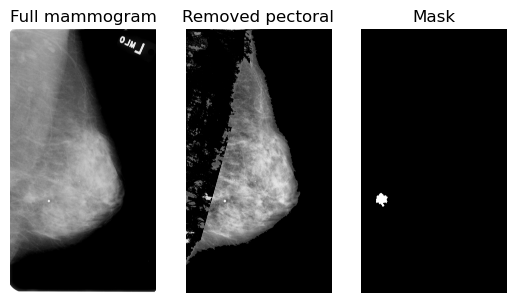

The image is an MLO view, do segmentation.


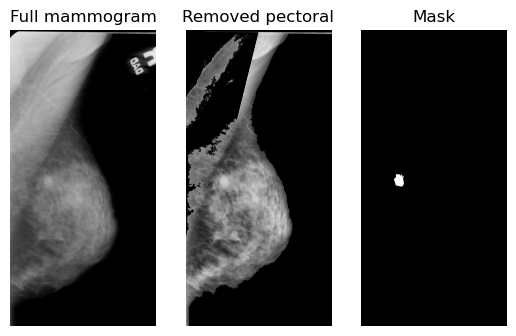

The image is an MLO view, do segmentation.


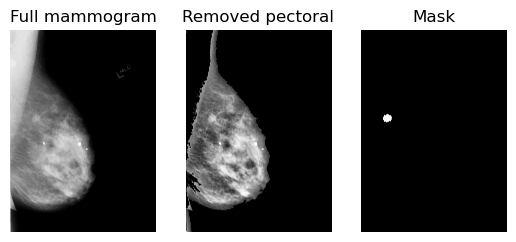

The image is an MLO view, do segmentation.


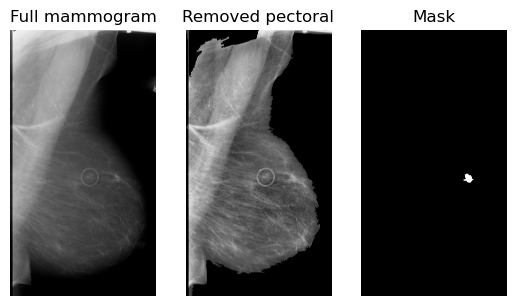

The image is an MLO view, do segmentation.


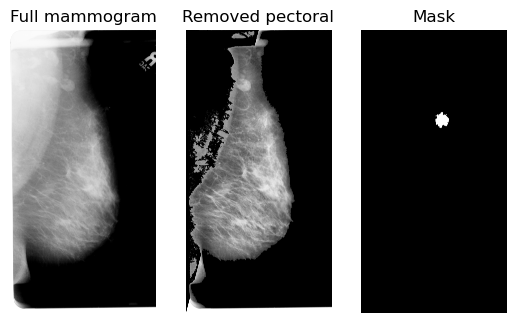

In [11]:
removed_pectoral_mammo = np.zeros((SIZE,), dtype=object)

for i in range (SIZE): 
    if is_mlo_view(i):   
        removed_pectoral_mammo[i] = segment_pectoral_muscle(removed_artefacts_mammo[i], i)
        
        fig, axs = plt.subplots(1, 3)
        for ax in axs:
            ax.grid(False)   
            ax.axis('off')     
        axs[0].imshow(full_mammo[i],cmap='gray')
        axs[0].set_title("Full mammogram")
        axs[1].imshow(removed_pectoral_mammo[i],cmap='gray')
        axs[1].set_title("Removed pectoral")
        axs[2].imshow(mask[i],cmap='gray')
        axs[2].set_title("Mask")
        plt.show()

The image is an MLO view, do segmentation.


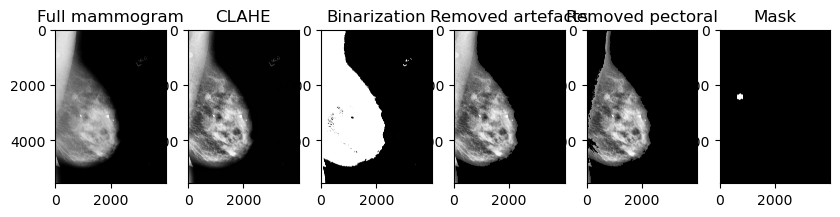

In [12]:
# Put preprocessing steps all together

def preprocess_image(image, df_index):
    # Apply preprocessing steps
    clahe_mammo = apply_clahe(image)
    simple_binarized_mammo = simple_binarization(clahe_mammo)
    removed_artefacts_mammo = remove_artefacts(clahe_mammo, simple_binarized_mammo)
    removed_pectoral_mammo = segment_pectoral_muscle(removed_artefacts_mammo, df_index)
    return removed_pectoral_mammo

image_preprocessed = preprocess_image(full_mammo[4], 4)

image=full_mammo[4]
clahe_mammo = apply_clahe(image)
simple_binarized_mammo = simple_binarization(clahe_mammo)
removed_artefacts_mammo = remove_artefacts(clahe_mammo, simple_binarized_mammo)
    
fig, ax = plt.subplots(1, 6, figsize=(10, 5))
ax[0].imshow(full_mammo[4], cmap="gray")
ax[0].set_title("Full mammogram")
ax[1].imshow(clahe_mammo, cmap="gray")
ax[1].set_title("CLAHE")
ax[2].imshow(simple_binarized_mammo, cmap="gray")
ax[2].set_title("Binarization")
ax[3].imshow(removed_artefacts_mammo, cmap="gray")
ax[3].set_title("Removed artefacts")
ax[4].imshow(image_preprocessed, cmap="gray")
ax[4].set_title("Removed pectoral")
ax[5].imshow(mask[4], cmap="gray")
ax[5].set_title("Mask")
plt.show()
